In [1]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [2]:
# GLOBAL SETTINGS

# Directories
model_dataDir = 'DATA/MODELDATA/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time
START = 2020
END = 2022



#Helpers
idx = pd.IndexSlice



In [3]:
# Helper Functions
def get_trade_prices(start, stop):
    model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
    model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
    model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
    model_mdf.set_index(['Dates', 'Coin'], inplace=True)
    model_mdf = model_mdf.loc[:,'Open']
    #model_mdf = model_mdf.loc[idx[Coin, str(START):str(END)], 'Open']
    prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')
    
    return prices



def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()


def get_factor(predictions):
    return (predictions.unstack('Coin')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='Dates')
            .sort_index())    

In [4]:
# Load the Model Results Data
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_scores = pd.read_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Load the OHLV Price data
#model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
#model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
#model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
#model_mdf.set_index(['Dates', 'Coin'], inplace=True)
#model_mdf = model_mdf.loc[:,'Open':'Volume']
#prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')

In [5]:
# Now we will check the Alpha and Beta metrics of the signals found by our models in the prior step

In [6]:
# From Linear Regression
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

Dates                      Coin       
2020-02-20 00:00:00+00:00  binancecoin    0.011773
                           bitcoin        0.000512
                           cardano       -0.036689
                           ethereum       0.006289
                           ripple         0.005602
dtype: float64

In [7]:
trade_prices = get_trade_prices(START, END)
#trade_prices.info()

In [8]:
#trade_prices = trade_prices.loc['2021':]
trade_prices = trade_prices.loc[str(START):]

In [9]:
trade_prices.head()

Coin,binancecoin,bitcoin,cardano,ethereum,ripple
Dates,,,,,
2020-01-01 00:00:00+00:00,13.522027,7139.044338,0.032875,129.544415,0.191127
2020-01-02 00:00:00+00:00,13.579740,7196.883716,0.033663,129.633809,0.190122
2020-01-03 00:00:00+00:00,13.650140,7320.309525,0.033864,133.711140,0.192036
2020-01-04 00:00:00+00:00,13.972162,7448.688305,0.034543,135.985074,0.194730
2020-01-05 00:00:00+00:00,14.380112,7520.122401,0.035271,139.236768,0.196440


In [10]:
trade_prices.tail()

Coin,binancecoin,bitcoin,cardano,ethereum,ripple
Dates,,,,,
2022-02-13 00:00:00+00:00,394.450842,42013.897363,1.034247,2868.907982,0.795925
2022-02-14 00:00:00+00:00,416.348931,43535.738493,1.070399,3017.804255,0.822834
2022-02-15 00:00:00+00:00,430.162619,43933.667693,1.088921,3125.767737,0.833197
2022-02-16 00:00:00+00:00,425.029510,43656.991021,1.070817,3068.487961,0.824512
2022-02-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN


In [11]:
# Get forward returns and Quantiles
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      #periods=(1, 7, 14, 30, 60, 90))
                                                      periods=(1, 7, 14, 30))

lr_factor_data.info()

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3495 entries, (Timestamp('2020-02-20 00:00:00+0000', tz='UTC', freq='C'), 'binancecoin') to (Timestamp('2022-01-18 00:00:00+0000', tz='UTC', freq='C'), 'ripple')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               3495 non-null   float64
 1   7D               3495 non-null   float64
 2   14D              3495 non-null   float64
 3   30D              3495 non-null   float64
 4   factor           3495 non-null   float64
 5   factor_quantile  3495 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 196.2+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.554991,0.129015,-0.034418,0.067011,699,20.0
2,-0.461923,0.147878,-0.014053,0.059701,699,20.0
3,-0.425358,0.168884,-0.001853,0.058387,699,20.0
4,-0.392591,0.207900,0.011750,0.057596,699,20.0
5,-0.354007,0.283065,0.032127,0.061620,699,20.0


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,0.117,0.003,0.008,-0.204
beta,0.022,-0.057,-0.062,0.216
Mean Period Wise Return Top Quantile (bps),8.209,0.467,-9.411,1.545
Mean Period Wise Return Bottom Quantile (bps),-9.592,3.138,-6.471,-12.478
Mean Period Wise Spread (bps),17.801,-1.984,-5.267,1.013


Information Analysis


,1D,7D,14D,30D
IC Mean,0.016,0.023,0.038,0.030
IC Std.,0.531,0.529,0.510,0.525
Risk-Adjusted IC,0.030,0.044,0.075,0.058
t-stat(IC),0.783,1.167,1.981,1.534
p-value(IC),0.434,0.244,0.048,0.125
IC Skew,-0.011,-0.041,-0.083,-0.061
IC Kurtosis,-1.057,-0.997,-1.023,-1.070


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.312,0.744,0.832,0.777
Quantile 2 Mean Turnover,0.556,0.786,0.812,0.779
Quantile 3 Mean Turnover,0.579,0.805,0.819,0.800
Quantile 4 Mean Turnover,0.511,0.790,0.815,0.816
Quantile 5 Mean Turnover,0.327,0.721,0.790,0.771


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.72,0.119,-0.046,0.019


<Figure size 432x288 with 0 Axes>

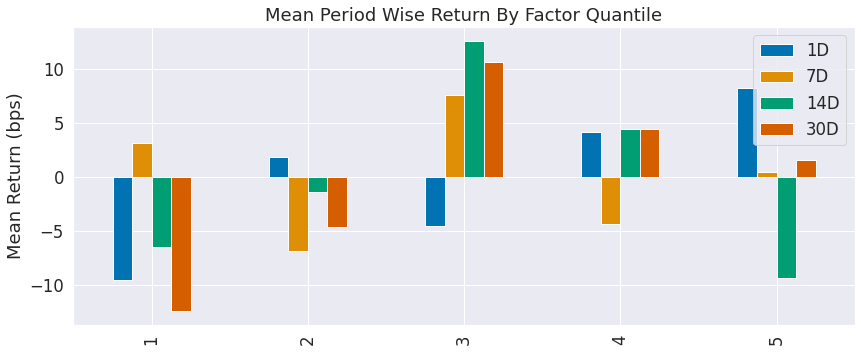

In [12]:
create_summary_tear_sheet(lr_factor_data);

In [13]:
# From Ridge
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [14]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

Dates                      Coin       
2020-02-20 00:00:00+00:00  binancecoin   -0.000717
                           bitcoin       -0.004611
                           cardano       -0.002650
                           ethereum      -0.011181
                           ripple        -0.010137
dtype: float64

In [15]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 7, 14, 30))
ridge_factor_data.info()

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3495 entries, (Timestamp('2020-02-20 00:00:00+0000', tz='UTC', freq='C'), 'binancecoin') to (Timestamp('2022-01-18 00:00:00+0000', tz='UTC', freq='C'), 'ripple')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               3495 non-null   float64
 1   7D               3495 non-null   float64
 2   14D              3495 non-null   float64
 3   30D              3495 non-null   float64
 4   factor           3495 non-null   float64
 5   factor_quantile  3495 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 196.2+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.173274,0.038712,-0.013045,0.018579,699,20.0
2,-0.165295,0.044090,-0.006579,0.017168,699,20.0
3,-0.147865,0.064194,-0.002536,0.016857,699,20.0
4,-0.144717,0.100487,0.001756,0.017056,699,20.0
5,-0.136341,0.138697,0.007381,0.018611,699,20.0


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,-0.042,0.025,0.046,-0.093
beta,-0.045,-0.054,-0.035,0.311
Mean Period Wise Return Top Quantile (bps),0.156,3.708,3.216,21.919
Mean Period Wise Return Bottom Quantile (bps),1.466,9.429,1.240,-24.448
Mean Period Wise Spread (bps),-1.310,-6.226,1.540,25.199


Information Analysis


,1D,7D,14D,30D
IC Mean,0.033,0.027,0.024,0.070
IC Std.,0.527,0.530,0.554,0.538
Risk-Adjusted IC,0.063,0.051,0.043,0.130
t-stat(IC),1.671,1.342,1.127,3.433
p-value(IC),0.095,0.180,0.260,0.001
IC Skew,-0.053,-0.077,0.050,-0.099
IC Kurtosis,-0.980,-0.883,-1.132,-1.118


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.322,0.605,0.695,0.740
Quantile 2 Mean Turnover,0.530,0.766,0.780,0.813
Quantile 3 Mean Turnover,0.560,0.777,0.756,0.773
Quantile 4 Mean Turnover,0.536,0.754,0.782,0.774
Quantile 5 Mean Turnover,0.355,0.652,0.701,0.732


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.702,0.286,0.15,0.083


<Figure size 432x288 with 0 Axes>

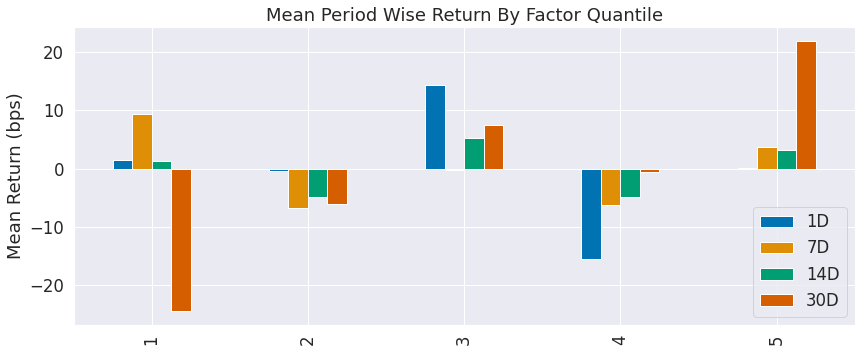

In [16]:
create_summary_tear_sheet(ridge_factor_data);

In [17]:
# From Lasso
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [18]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

Dates                      Coin       
2020-02-20 00:00:00+00:00  binancecoin    0.002996
                           bitcoin       -0.006562
                           cardano       -0.045146
                           ethereum      -0.002295
                           ripple        -0.003287
dtype: float64

In [19]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 7, 14, 30))
lasso_factor_data.info()

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3495 entries, (Timestamp('2020-02-20 00:00:00+0000', tz='UTC', freq='C'), 'binancecoin') to (Timestamp('2022-01-18 00:00:00+0000', tz='UTC', freq='C'), 'ripple')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               3495 non-null   float64
 1   7D               3495 non-null   float64
 2   14D              3495 non-null   float64
 3   30D              3495 non-null   float64
 4   factor           3495 non-null   float64
 5   factor_quantile  3495 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 196.2+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.575799,0.136029,-0.038000,0.065500,699,20.0
2,-0.451899,0.155119,-0.018239,0.057624,699,20.0
3,-0.446715,0.175754,-0.005971,0.055833,699,20.0
4,-0.413848,0.200787,0.007135,0.055477,699,20.0
5,-0.375452,0.275866,0.026524,0.059052,699,20.0


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,0.016,-0.017,-0.002,-0.189
beta,-0.020,-0.032,-0.048,0.214
Mean Period Wise Return Top Quantile (bps),3.850,-1.118,-8.998,3.780
Mean Period Wise Return Bottom Quantile (bps),-6.459,2.885,-4.765,-10.761
Mean Period Wise Spread (bps),10.309,-3.422,-6.486,2.090


Information Analysis


,1D,7D,14D,30D
IC Mean,0.012,0.014,0.034,0.037
IC Std.,0.534,0.527,0.518,0.530
Risk-Adjusted IC,0.023,0.027,0.066,0.070
t-stat(IC),0.602,0.710,1.752,1.862
p-value(IC),0.548,0.478,0.080,0.063
IC Skew,-0.022,0.000,-0.077,-0.086
IC Kurtosis,-1.051,-0.995,-1.028,-1.073


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.330,0.736,0.848,0.779
Quantile 2 Mean Turnover,0.557,0.776,0.806,0.789
Quantile 3 Mean Turnover,0.587,0.795,0.816,0.782
Quantile 4 Mean Turnover,0.539,0.786,0.828,0.819
Quantile 5 Mean Turnover,0.330,0.721,0.782,0.762


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.729,0.135,-0.051,0.033


<Figure size 432x288 with 0 Axes>

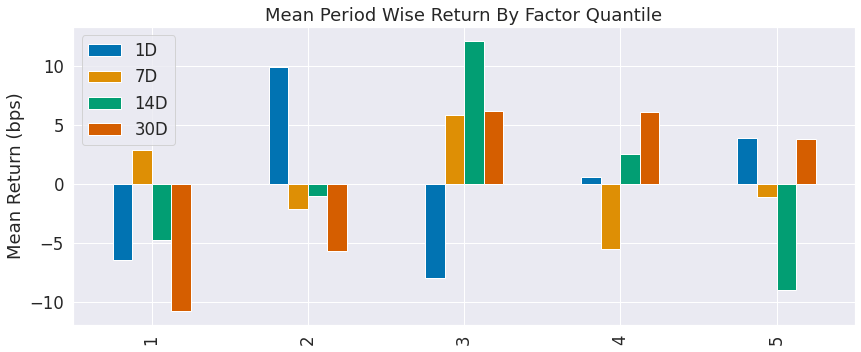

In [20]:
create_summary_tear_sheet(lasso_factor_data);